In [9]:
!pip install -q kaggle

from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets list

!kaggle datasets download -d zalando-research/fashionmnist

!unzip fashionmnist.zip

Saving kaggle.json to kaggle.json
ref                                                           title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
anandshaw2001/netflix-movies-and-tv-shows                     Netflix Movies and TV Shows                         1MB  2025-01-03 10:33:01          13344        346  1.0              
asinow/car-price-dataset                                      Car Price Dataset                                 135KB  2025-01-26 19:53:28           2866         42  1.0              
ankushpanday1/alzheimers-prediction-dataset-global            Alzheimer’s Prediction Dataset (Global)             1MB  2025-01-30 14:38:39           1203         29  1.0              
himelsarder/road-accident-survival-dataset    

In [10]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [12]:
torch.manual_seed(42)

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


# EDA

In [14]:
df = pd.read_csv('/content/fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


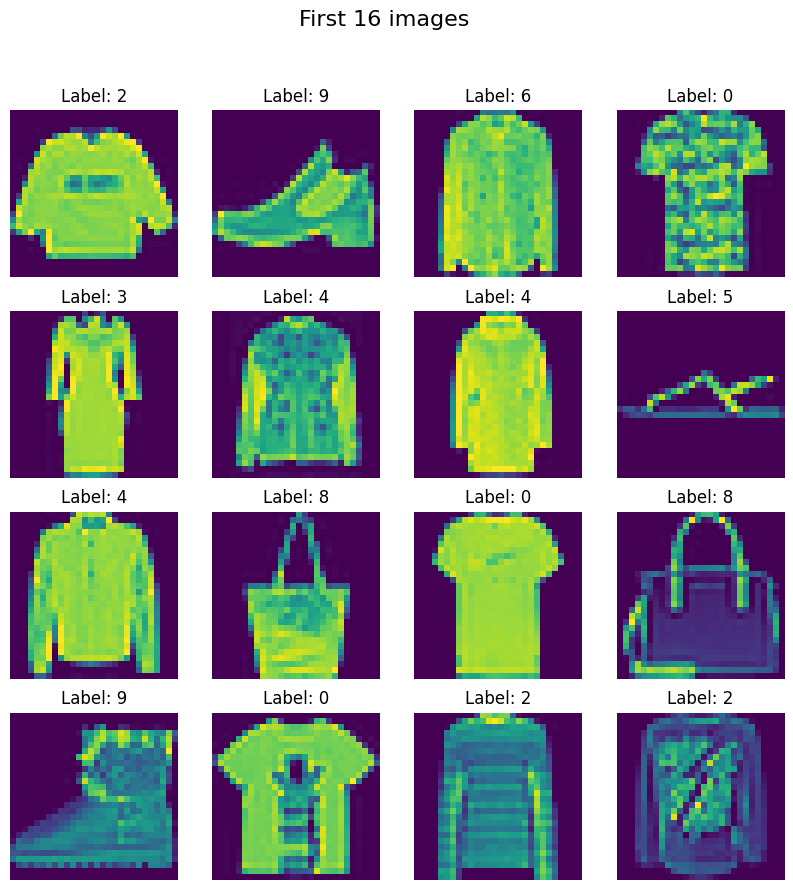

In [15]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 images", fontsize=16)

for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Label: {df.iloc[i, 0]}")

plt.show()

In [16]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transform data according to VGG guidelines

In [17]:
from torchvision.transforms import transforms

custom_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create custom dataset and dataloader instances

In [18]:
from PIL import Image
import numpy as np

In [19]:
class CustomDataset(Dataset):

    def __init__(self, features, labels, transform):
        super().__init__()
        self.features = features
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):

        # resize to (28, 28)
        image = self.features[index].reshape(28, 28)

        # change datatype to np.uint8
        image = image.astype(np.uint8)

        # change black and white to colour
        image = np.stack([image] * 3, axis = -1)

        # convert array to PIL image
        image = Image.fromarray(image)

        # apply transform
        image = self.transform(image)

        return (image, torch.tensor(self.labels[index], dtype=torch.long))


# Create train_dataset and test_dataset objects

In [20]:
train_dataset = CustomDataset(X_train, y_train, custom_transform)

In [21]:
test_dataset = CustomDataset(X_test, y_test, custom_transform)

# Create train_loader and test_loader objects

In [22]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

# Define the CNN

In [23]:
# Now using transfer learning
import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)

# class CNN(nn.Module):

#     def __init__(self, input_features):
#         super().__init__()

#         self.features = nn.Sequential(
#             nn.Conv2d(input_features, 32, kernel_size=3, padding='same'),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             nn.Conv2d(32, 64, kernel_size=3, padding='same'),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#         )
#         self.classifier = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(64 * 7 * 7, 128),
#             nn.ReLU(),
#             nn.Dropout(p=0.4),

#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Dropout(p=0.4),

#             nn.Linear(64, 10)
#         )

#     def forward(self, X):
#         out = self.features(X)
#         out = self.classifier(out)
#         return out

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 121MB/s]


In [24]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [25]:
vgg16.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [26]:
for param in vgg16.features.parameters():
  param.requires_grad = False

In [27]:
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [28]:
vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(512, 10)
)

In [29]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [30]:
vgg16 = vgg16.to(device)

In [31]:
learning_rate=0.0001
epochs=10

In [32]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=learning_rate)

In [ ]:
# training loop
for epoch in range(epochs):

    total_epoch_loss = 0

    for batch_features, batch_labels in train_loader:

        # move batch_features and batch_labels to GPU
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        # forward pass
        y_train_pred = vgg16(batch_features)

        # calculate loss
        loss = loss_function(y_train_pred, batch_labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # update grads
        optimizer.step()

        total_epoch_loss += loss.item()

    avg_epoch_loss = total_epoch_loss / len(train_loader)

    print(f"Epoch: {epoch + 1}, Loss: {avg_epoch_loss}")

Epoch: 1, Loss: 0.3663459859912594


In [ ]:
vgg16.eval()

CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [ ]:
total = 0
correct = 0

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        # move batch_features and batch_labels to GPU
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        y_test_pred = vgg16(batch_features)
        y_test_pred = torch.argmax(y_test_pred, dim=1)
        total += batch_labels.shape[0]
        correct += (y_test_pred == batch_labels).sum().item()

accuracy = correct / total

print(accuracy)

0.9205


In [ ]:
total = 0
correct = 0

with torch.no_grad():
    for batch_features, batch_labels in train_loader:
        # move batch_features and batch_labels to GPU
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        y_train_pred = vgg16(batch_features)
        y_train_pred = torch.argmax(y_train_pred, dim=1)
        total += batch_labels.shape[0]
        correct += (y_train_pred == batch_labels).sum().item()

accuracy = correct / total

print(accuracy)

0.9991458333333333
